# React agent with multiple tool

In [111]:
import operator
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import  TypedDict, Annotated,Sequence
import operator
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


In [12]:
load_dotenv()

True

In [13]:
model="deepseek-r1-distill-llama-70b"

In [14]:
llm = ChatGroq(model_name=model)

In [15]:
llm.invoke("What is the capital of France?")

AIMessage(content='<think>\n\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 10, 'total_tokens': 22, 'completion_time': 0.04855961, 'prompt_time': 0.000204237, 'queue_time': 0.207688601, 'total_time': 0.048763847}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6dd72fa-27e2-434e-9b73-764d42f6a6ea-0', usage_metadata={'input_tokens': 10, 'output_tokens': 12, 'total_tokens': 22})

In [85]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]} # state.update(messages=messages + [response])

In [86]:
state = {"messages": ["Hi!!! Hello, how are you?"]}

In [87]:
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHi! Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you! How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 11, 'total_tokens': 51, 'completion_time': 0.191585047, 'prompt_time': 0.000301095, 'queue_time': 0.202527335, 'total_time': 0.191886142}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--b98be121-78ae-473c-ae83-3b13a840407a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 40, 'total_tokens': 51})]}

In [54]:
graph = StateGraph(MessagesState)

In [55]:
graph.add_node("call_model", call_model)

In [56]:
graph.add_edge(START, "call_model")
graph.add_edge("call_model", END)

In [57]:
workflow = graph.compile()

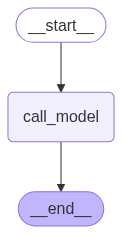

In [58]:
display(workflow)

In [61]:
# input_state = {"messages": [HumanMessage(content="What is your name?")]} # ["Hi!!! Hello, how are you?"]}# MessagesState(messages=["Hi!!! Hello, how are you?"])

input_state = {"messages": ["Hi!!! Hello, how are you?"]} # MessagesState(messages=["Hi!!! Hello, how are you?"])

output = workflow.invoke(input_state)

In [64]:
output["messages"][-1].content

"<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you! How are you doing? 😊"

In [90]:
@tool
def search(query:str):
    """
    Customer tool to search weather.
    """
    if "delhi" in query.lower():
        return "the temperature in Delhi is 45 degrees Celsius and sun is shining."
    return "I don't know the weather in that city."

In [91]:
search.invoke("What is the weather in Delhi?")

'the temperature in Delhi is 45 degrees Celsius and sun is shining.'

In [92]:
search.invoke("What is the weather in Mumbai?")

"I don't know the weather in that city."

In [93]:
tools = [search]

llm_with_tools = llm.bind_tools(tools)

In [94]:
response = llm_with_tools.invoke("What is the weather in Delhi?")

In [96]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'Delhi weather'},
  'id': 'v4er0n5n4',
  'type': 'tool_call'}]

In [102]:
def call_model_with_tools(state: MessagesState) -> MessagesState:
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":[response]}

In [106]:
weather_query = {"messages": ["What is the weather in Delhi?"]}

In [107]:
res = call_model_with_tools(weather_query)

In [108]:
res["messages"][-1].content

''

In [109]:
res["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'Delhi'},
  'id': 'v6gg1n4xs',
  'type': 'tool_call'}]

In [110]:
def router_function(state: MessagesState) -> MessagesState:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END


In [114]:
tool_node = ToolNode(tools)

In [116]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='Customer tool to search weather.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x12e71fba0>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [127]:
weather_graph = StateGraph(MessagesState)
weather_graph.add_node("llmwithtool", call_model_with_tools)
weather_graph.add_node("tools", tool_node)
weather_graph.add_edge(START, "llmwithtool")

weather_graph.add_conditional_edges("llmwithtool", router_function, {"tools": "tools", END: END})

In [128]:
weather_flow = weather_graph.compile()

In [129]:
weather_flow.invoke({"messages": ["What is the weather in Mumbai?"]})

{'messages': [HumanMessage(content='What is the weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='064f47ac-a529-41e4-9a23-5a2d6b0938b3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'sjtbrj1kx', 'function': {'arguments': '{"query":"Mumbai"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 128, 'total_tokens': 213, 'completion_time': 0.378862451, 'prompt_time': 0.008205925, 'queue_time': 0.057122639, 'total_time': 0.387068376}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8f3bf074-7c77-4cf1-b53b-38863c0c3475-0', tool_calls=[{'name': 'search', 'args': {'query': 'Mumbai'}, 'id': 'sjtbrj1kx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 128, 'output_tokens': 85, 'total_tokens': 213}),
  ToolMessage(content="I don't know the weather in that city.", name='search', id='6ef0d

In [130]:
weather_flow.invoke({"messages": ["What is the weather in Delhi?"]})

{'messages': [HumanMessage(content='What is the weather in Delhi?', additional_kwargs={}, response_metadata={}, id='1c85fe61-0825-4ca1-bc49-0943c55c0447'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'b43d2y04h', 'function': {'arguments': '{"query":"Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 190, 'prompt_tokens': 128, 'total_tokens': 318, 'completion_time': 0.766702768, 'prompt_time': 0.008212915, 'queue_time': 0.208579015, 'total_time': 0.774915683}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9ce66bdc-88e9-42c0-9cb9-be03f112ca41-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi'}, 'id': 'b43d2y04h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 128, 'output_tokens': 190, 'total_tokens': 318}),
  ToolMessage(content='the temperature in Delhi is 45 degrees Celsius and sun is shining.

In [131]:
weather_flow.invoke({"messages": ["What's the latst new in Agentic AI?"]})

{'messages': [HumanMessage(content="What's the latst new in Agentic AI?", additional_kwargs={}, response_metadata={}, id='7c3da9d8-16e3-429d-9c0e-87f02c1adc21'),
  AIMessage(content="Agentic AI has recently announced the release of its advanced language model, which now includes enhanced capabilities for natural language understanding and generation. This update improves the model's ability to handle complex queries and generate more coherent responses. Additionally, Agentic AI has entered into a strategic partnership with a leading tech firm to integrate its AI solutions into various industry applications, further expanding its reach in the market. The company has also published a new research paper detailing breakthroughs in AI efficiency and scalability, showcasing their commitment to innovation. For the most current information, I recommend checking their official announcements or recent news articles on tech platforms.", additional_kwargs={}, response_metadata={'token_usage': {'co